*Unit 4, Sprint 3, Module 1*

---


# 1. Recurrent Neural Networks (RNNs) and Long Short Term Memory (LSTM) -- Prepare



![](https://wiki.tum.de/download/attachments/22578349/GATES.gif?version=1&modificationDate=1486083227237&api=v2)

## Learning Objectives
- <a href="#p1">Part 1: </a>Describe How Neural Networks are used for modeling sequences
- <a href="#p2">Part 2: </a>Implement LSTM models for a text classification problem and a text generation problem

-----
## Overview

### Let's start with sequences 

A sequence is a collection of numbers, taking into account their order; repetition is allowed. 

Python lists are a good elemental example - `[1, 2, 2, -1]` is a valid list and is different from `[1, 2, -1, 2]`. 


## 1.1 Recursion (Learn)


A recursive function is a function that can call itself!<br><br>
For a recursive function to be defined, there must be a _base case_ that the function eventually reaches by repeatedly calling itself.<br><br>

###1.1.1 The factorial function
A simple example of recursion is the _factorial_ function, <br>
denoted by the character $!$ following a non-negative integer<br><br>
$n! \equiv n\cdot (n-1) \cdot (n-2) \cdot \ldots \cdot  1$ <br><br>
and $0! \equiv  1$,<br><br>
where $\equiv$ means "is defined as"<br>



In [3]:
def factorial(n):
  if(n==0 or n==1):
    return 1 #base case
  elif(n>1):
    return n*factorial(n-1) # recursion formula

5! = 5 x 4 x 3 x 2 x 1 =120

In [5]:
factorial(5)

120

###1.1.2 The Fibonacci Sequence

Before we dive into the inner workings of an LSTM model, let's try to understand and appreciate **recursion** in sequences. <br>A **recursive sequence** is a sequence in which the next number can be computed from one or more of the previous numbers via a [**recurrence relation**](https://en.wikipedia.org/wiki/Recurrence_relation). Recursion occurs in both pure mathematics and in the physical world in which we find ourselves embedded. <br><br>
The root word is **recur**, which means "to occur repeatedly". Given a few consecutive values, the rest of a recursive sequence can be generated by repeatedly applying its recursion relation! 


As usual, we attempt to understand a concept from at least 3 different perspectives:
- Algebraic
- Geometric
- Coding an example

A famous example of a recursive sequence in mathematics is the [Fibonacci numbers](https://en.wikipedia.org/wiki/Fibonacci_number). Fibonacci was an Italian mathematician, who wrote about these numbers in **The Book of Calculation**, in 1202 AD. Although the sequence is named after him, it was known long before his time in India.

The Fibonacci numbers are an infinite sequence of integers, beginning with $[0, 1]$ in which the $ith$ number (for $i>1$) is the sum of the two previous numbers.

Here is the algorithm for generating the numbers in the Fibonacci sequence: 

$$F_n = F_{n-1} + F_{n-2}$$

You need a **base case** $F_0=0$ and $F_1=1$ to get the sequence started.

Starting from the base case, the recursion relation generates the entire sequence:

$F_0=0,~~  F_1=1 $<br><br>

$F_2 = F_{1} + F_{0} ~=~ 1 + 0 ~=~ 1$<br><br>

Then

$F_3 = F_{2} + F_{1} ~=~ 1 + 1 ~=~ 2$<br><br>

Then 

$F_4 = F_{3} + F_{2} ~=~ 2 + 2 ~=~ 3$<br><br>

Then 

$F_5 = F_{4} + F_{3} ~=~ 3 + 2 ~=~ 5$<br><br>

etc.

Get the idea?

Now you try: what are $F_{6}$ and $F_{7}$?

#### ##Your answer here



### 1.1.3 The Fibonacci Sequence in Nature
Before coding up the Fibonacci sequence, let's take a moment to appreciate<br>
its beauty, and how important and ubiquitous it is in nature!

#### **Contruction of the ["Golden Spiral"](https://en.wikipedia.org/wiki/Golden_spiral)**
![](http://www.davidbeahm.com/wp-content/uploads/2011/11/fibonacci-1024x637.jpg)

#### **Snail Shells**
![](https://i.pinimg.com/originals/32/d7/47/32d747bea24f4756dc4c5ffe61b36efd.jpg)

#### **The Mona Lisa**
![](https://i.pinimg.com/originals/f2/cb/34/f2cb3452dd774bab87bbee2b8a77d4bb.png)

#### **A Spiral Galaxy**
![](https://f4.bcbits.com/img/a3628582449_10.jpg)



#### **Take Away:** 
- There are often surprising connections between mathematics and physical phenomena
- The world contains many examples of recursive sequences


### 1.1.4 Coding the Fibonacci Sequence using a recursive function
*This is a standard problem that often comes up in interviews for software engineering jobs!*<br>

Recall: A recursive function is a function that can call itself.<br>
For a recursive function to be defined, there must be a _base case_ that the function eventually reaches by repeatedly calling itself.<br>

For the Fibonacci sequence, the _base case_ is<br><br>
$$F_0=0 ~\text{and}~ F_1=1$$<br><br>
Again, here is the algorithm for the Fibonacci numbers.  


$$F_n = F_{n-1} + F_{n-2}$$<br>

So we want a recursive function that, given an integer $n$ computes the $nth$ Fibonacci number by repeatedly calling itself.


In [6]:
def fibo(n):
    """
    Calculate and return the next number in the Fibonacci sequence
    
    Input
    -----
    n: int or float
        The nth number in the sequence (think of it as an index for a list)
        
    Return
    ------
    F_n: the next number in the sequence generated from the previous two numbers in the sequence 
    """
    
    if n <= 1: # this is the base case
        F_n = n## YOUR CODE HERE
    elif n > 1: # this is the recursive case, where the function calls itself!
        F_n = fibo(n-1) + fibo(n-2) ## YOUR CODE HERE
    return F_n    

In [7]:
# Using our recursive function, generate the first 10 values of the Fibonacci Sequence
###BEGIN SOLUTION
[fibo(n) for n in range(10)]
###END SOLUTION

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34]

In [8]:
fibo(20)

6765

**Take Away:** 

Recursive algorithms have as input their previous output. <br>
In other words, the output at time step $t - 1$, becomes the input for the following time step $t$.<br><br> 
This key idea of recursion underlies the construction of a Recurrent Neural Networks (RNNs).

-----

## 1.2 Introduction to Recursive Neural Networks (RNNs) 


Now that we've gained insight into the recursion process, we can build on <br>
our intuition to help us understand how RNNs and LSTMs work. 

Recurrent Neural Networks (RNNs) have a recursive loop in their architecture. The RNN model was first formulated in the original [backpropagation paper](https://chsasank.com/classic_papers/learning-representations-back-propogating-errors.html#) by Rumelhart et al. in 1986, based on the standard Fully-Connected Feed-Forward (FCFF) model: 


![](https://upload.wikimedia.org/wikipedia/commons/b/b5/Recurrent_neural_network_unfold.svg)

The hidden state $\textbf{h}$ has the same dimensionality as the input vector $\textbf{x}$ and is updated at each time step $t$, according to _two inputs_: $x_t$ **and** the previous hidden state $h_{t-1}$. Since for the first input $x_{0}$, the previous hidden state is undefined, it is often initialized to all zeros.  <br><br>

The key to the RNN is the recursive use of the _hidden state_ to learn and carry forward information about all the _previous_ elements of the input sequence. 

In principle, this "memory" feature of the RNN is an exciting concept that holds the promise to go beyond "bag-of-words" models in NLP to be able to encode contextual meaning of sequences of words in documents. However, the practical limitations of RNNs has prevented them from fully delivering on this promise. <br><br>

RNNs
- don't have long-term memory capacity, so cannot learn from input sequences longer than a few dozen elements long
- suffer from the [Vanishing Gradient Problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).<br><br>

To mitigate against these limitations, Hochreiter and Schmidhuber invented the [LSTM model](https://papers.nips.cc/paper/1215-lstm-can-solve-hard-long-time-lag-problems.pdf) in 1996.<br><br>
The LSTM model abandons the FCFF architecture in favor of the following architecture:

![Long short-term memory unit](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Long_Short-Term_Memory.svg/1024px-Long_Short-Term_Memory.svg.png)

Wow! There's a lot going on here, isn't there? <br>
In the next section, we'll break down the LSTM model bit-by-bit so, we can understand a bird's eye view of what is happening. 

_____


## 1.3 Overview of the LSTM (Long Short Term Memory)

For this course we will regard the LSTM as a black box, which functions as souped-up, more powerful version of the RNN. You will be responsible for being able to implement and use the LSTM models. Understanding how LSTMs work under the hood is optional, depending on your curiosity and interest.

### 1.3.1 The "vanishing gradient" problem.  

RNNs and LSTMs, like other neural networks we've encountered, are trained using backpropagation with some form of gradient descent. For an "unrolled" RNN (or LSTM), backpropagation has to go back through the entire time sequence of states, which is why it's called BPTT (backpropagation through time). If a gradient "vanishes", i.e. becomes close to zero somewhere along the line, the parameter updates also "vanish", and network training slows down and grinds to a halt because the parameters are becoming vanishingly small. _This is the "vanishing gradient problem", which LSTMs were invented to solve_. LSTMs are superior to RNNs because they can remember longer sequences and do not suffer from vanishing gradients.

[Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Chris Olah presents a beautifully clear and concise explanation of the model's architecture and the mathematics (mostly matrix multiplication) behind it. This article will serve as our main resource for understanding how LSTMs work. 

Below are the equations for each of the gates in the LSTM architecture that are explained in the article. 

Although, you will not be held responsible for the equations in any quiz, module assignment, or Sprint Challenge - it is still instructive to have a look at the machinery inside the black box.

First thing to notice is that each gate equation (not the cell states) has the form of a perceptron. 

Remember the perceptron? It's the fundamental building block of neural networks - it's not going away! 

Once you understand that, it will hopefully become gradually clear that each gate is a perceptron with a different job to do. 

That's it. 

It's just 4 perceptrons, each with a different job to do. 

Fortunately, you already know about perceptrons (you built one from scratch in `Sprint 2 Module 1`). 

____

### 1.3.2 LSTM Gates

#### Forget Gate
This neuron's job is to use the current input to learn what information the cell state should forget regarding long-term dependencies. 


$$f_t = \sigma(W_f \cdot [h_{t-1},x_t]~+~b_f)$$

#### Input Gate
This neuron's job is to use the current input to learn what new information to include in the cell state. 


$$i_t = \sigma(W_i \cdot [h_{t-1},x_t]~+~b_i)$$

#### Candidate Cell State 
This neuron's job is to use the current input to create a candidate cell state.

This new candidate cell state will be used to update the model's final cell state.

$$\tilde{C}_t = \text{tanh}(W_C \cdot [h_{t-1},x_t]~+~b_C)$$

#### New Cell State
This is where the candidate and old cell state are combined to create a new cell state.

This is where output from the forget gate $f_t$ is used to scale the old cell state

- If $f_t$ is closer to $0.0$, then less information from the previous cell state is retained.
- If $f_t$ is closer to $1.0$, then more information from the previous cell state is retained. 


This is also where the output of the input gate $i_t$ is used to scaled the candidate cell state. 
- If $i_t$ is closer to $0.0$, then less information from the candidate cell state is retained
- If $i_t$ is closer to $1.0$, then more information from the candidate cell state is retained. 

Finally, you form a linear combination of the cell state $C_{t-1}$ from the previous time step with the candidate cell state $\tilde{C}_{t}$ from the current time step to form the model's new cell state $C_{t}$ of the model. 

It is $C_t$ that will be passed into the next training step and used by the output to make a final prediction. 

$$C_t = f_t*C_{t-1} + i_t*\tilde{C}_t$$

#### Output Gate
This is where the actual output of the model is calculated. 

This neuron's job is to take the current input and make a prediction. 

$$o_t = \sigma(W_o \cdot [h_{t-1},x_t]~+~b_o)$$

Next, the cell state is used to inform the final prediction. 

Recall that $o_t$ is the output of a sigmoid activation function, so its value is somewhere between 0 and 1. 

$o_t$ is used to scale $\text{tanh}(C_t)$, which contains the current cell state. <br><br>
The model's final output is 
$$h_t = o_t*\text{tanh}(C_t)$$<br><br>

Recall that the tanh activation maps numbers on the real line to numbers on the interval $[-1,1]$.<br>
So the presence of the factor $\text{tanh}(C_t)$ makes it possible to have positive **or  negative** values for the model's final output. <br>
Sigmoids don't allow for the possibility of negative values, but tanh does. 


The article denotes the model's pre-scaled output as $o_t$ and the final output as $h_t$. <br>
To be clear, $h_t$ is the model's final prediction, while  $o_t$ is an intermediate step. <br>
We are familiar with the notation $y$ to denote a model's prediction instead of using $h$. <br>
In the LSTM, they both mean the same thing - the model's final prediction. 




_________

##1.4 Applications of LSTMs

So why are LSTMs cool? 

One compelling application is **language modeling** - language is inherently ordered data (letters/words go one after another, and the order *matters*). [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) is a famous blog post by Andrej Karpathy on this topic, worth reading.<br><br>

A language model is simply a model that, given some text, predicts the most likely next word, or character.<br><br>
Language models are essentially self-supervised -- the "label" or "target" for any text string is the next word (or character). <br>
The data set already has the answers!

Another interesting application of LSTMs is to text classification problems such as the sentiment classification problem we encountered in Unit 4, Sprint 1. Since LSTMs can learn contextual information about sequences of words, they can learn for example, that "the service is not so great" does not indicate a positive sentiment.

For our purposes, we'll use TensorFlow and Keras to train LSTMs with text data. 

Resources:
- https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py
- https://keras.io/layers/recurrent/#lstm
- http://adventuresinmachinelearning.com/keras-lstm-tutorial/


Note: These days, [Transformer models](https://jalammar.github.io/illustrated-transformer/) surpass LSTMs for most Natural Language Processing tasks. Interestingly, people have recently adapted Transformers -- which were developed to solve text NLP problems --- to work with Computer Vision tasks, and their performance now rivals that of Convolutional Neural Networks (which we'll introduce in the next Module)! So if you're interested in learning about state of the art NLP models, your next step is Transformers. The [Free Hugging Face Transformers Course](https://huggingface.co/course/chapter1) is a great resource.


# 2. Sentiment Classification with RNN/LSTM -- Follow Along

_____________

RNNs and LSTMs are great for modeling any kind of data that comes in ordered sequences. <br>
There are an astonishing variety of sequences in our world, such as 
* words in a document
* musical notes or chords in a song
* sounds in an audio recording
* daily stock prices
* DNA base pairs
* medical sensor time series data, such as voltage measurements in an EKG
* etc.!<br>

Can you think of other examples of sequence data?<br>

To illustrate the power of Neural Networks for modeling sequences,<br>
we'll focus on text data, and apply LSTMs to a simple sentiment classification task.<br>

The [Internet Movie Database (IMDb)](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data) is a database of movie reviews in text format, along with the sentiment label(positive or negative), coresponding to each review.

The movie review labels are binary:
* $1 \rightarrow$ the review expresses positive sentiment
* $0 \rightarrow$ the review expresses negative sentiment

In this exercise, we will train a **sentiment classification** model that can predict from the text whether a movie review is "thumbs-up" or "thumbs-down".

In [9]:
from __future__ import print_function
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# load in dataset 

# maximum number of words in vocab
max_features = 20000

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
17473536/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences


#### What does the IMDb data look like?
The data is a list of reviews<br>
Each review is a list of numerical word encodings.<br>
Each review may have a different number of words.<br>
The number of words in our vocabulary is 20000

In [12]:
print(type(x_train))
print(x_train.shape)
print(type(x_train[0]))
print(len(x_train[0]))
print(len(x_train[101]))


<class 'numpy.ndarray'>
(25000,)
<class 'list'>
218
145


Here is the (numerically encoded first review)

In [13]:
x_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 19193,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 10311,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 12118,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,

### What's are the lengths of the longest and shortest reviews in the training set?

In [14]:
print(f'longest review is { np.max( [len(x_train[i]) for i in range(len(x_train))]) } words')
print(f'shortest review is { np.min( [len(x_train[i]) for i in range(len(x_train))]) } words')

longest review is 2494 words
shortest review is 11 words


### Truncating and padding the reviews to the same length
We will standardize the length of our movie reviews as follows
* Reviews that are longer than a `maxlen` value that we specify will be truncated to the first `maxlen` words
* Reviews that are shorter than `maxlen` will be padded with 0s (or some other value that you provide) at the end to increase their length to `maxlen`.


In [15]:
maxlen = 80

###BEGIN SOLUTION
print('Pad Sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen,padding='pre',truncating = 'post')
x_test = sequence.pad_sequences(x_test, maxlen=maxlen, padding='pre',truncating = 'post')
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)
###END SOLUTION

Pad Sequences (samples x time)
x_train shape:  (25000, 80)
x_test shape:  (25000, 80)


#### each review is truncated to the first 80 words.

In [16]:
x_train[0]

array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468,   66, 3941,    4,  173,   36,  256,    5,   25,  100,   43,
        838,  112,   50,  670,    2,    9,   35,  480,  284,    5,  150,
          4,  172,  112,  167,    2,  336,  385,   39,    4,  172, 4536,
       1111,   17,  546,   38,   13,  447,    4,  192,   50,   16,    6,
        147, 2025,   19,   14,   22,    4, 1920, 4613,  469,    4,   22,
         71,   87,   12,   16,   43,  530,   38,   76,   15,   13, 1247,
          4,   22,   17], dtype=int32)

#### The "labels" (or "targets") are classes -- 0 for negative reviews and 1 for positive reviews.

In [17]:
np.unique(y_train)

array([0, 1])

### Build a LSTM language model with 1 hidden layer 

In [18]:
# build a 1 layer LSTM language model 
from tensorflow.keras.optimizers import Adam

# specify learning rate and optimizer
opt = Adam(learning_rate=1.e-7)

###BEING SOLUTION
# as usual, we begin to build our model by instantiating a Sequential class 
model = Sequential()

# input layer 
# adding an Embedding layer 
model.add(Embedding(input_dim=max_features, output_dim=128))

# hidden layer 1 
model.add(LSTM(128, return_sequences=False))

# output layer 
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=opt, 
              metrics=['accuracy'])

model.summary()
###END SOLUTION

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


How can we compute the number of parameters in this LSTM layer?<br>
Well, as we have seen, each LSTM unit has 4 neurons. <br>
The number of outputs (LSTM cells) is $128$. The number of inputs is $128$, which is also the length of the hidden state. The input to the LSTM can be considered as the concatenation of the inputs with the hidden state, so it has length $2\cdot n_{inputs}$ <br>
So the number of parameters in the LSTM layer is $n_{outputs}\cdot (2\cdot n_{inputs}+ 1)\cdot n_{neurons} = 128 \cdot (256+1)\cdot 4 = 131584$

### Use a learning rate schedule [callback](https://) to find the best learning rate!
Note that for this part, we don't need to pass the `test` data to the `fit` method.

In [19]:
%%time
# about 5 or 6 sec per epoch on Colab GPU
# specify batch size
batch_size = 32
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
     lambda epoch: 1e-5 * 10**(epoch/2))
results_one_layer = model.fit(x_train, y_train,
                      batch_size=batch_size, 
                      epochs=10, callbacks=[lr_schedule])

Epoch 1/10
782/782 [==============================] - 11s 7ms/step - loss: 0.6929 - accuracy: 0.5163
Epoch 2/10
782/782 [==============================] - 6s 7ms/step - loss: 0.6075 - accuracy: 0.6603
Epoch 3/10
782/782 [==============================] - 6s 7ms/step - loss: 0.4186 - accuracy: 0.8157
Epoch 4/10
782/782 [==============================] - 6s 7ms/step - loss: 0.3500 - accuracy: 0.8520
Epoch 5/10
782/782 [==============================] - 6s 7ms/step - loss: 0.3398 - accuracy: 0.8597
Epoch 6/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3666 - accuracy: 0.8476
Epoch 7/10
782/782 [==============================] - 6s 7ms/step - loss: 0.3683 - accuracy: 0.8433
Epoch 8/10
782/782 [==============================] - 6s 8ms/step - loss: 0.4610 - accuracy: 0.7948
Epoch 9/10
782/782 [==============================] - 6s 8ms/step - loss: 0.8919 - accuracy: 0.5180
Epoch 10/10
782/782 [==============================] - 6s 8ms/step - loss: 1.4024 - accuracy: 0.504

Backing off by by a factor of 10 from where the loss surface is unstable, we choose 1.e-4 as the best learning rate.

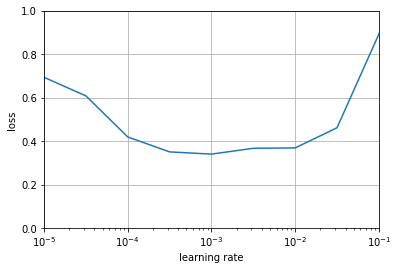

In [20]:
plt.semilogx(results_one_layer.history["lr"], results_one_layer.history["loss"])
plt.axis([1e-5, 1e-1, 0, 1])
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.grid()

In [28]:
# build a 1 layer LSTM language model 
from tensorflow.keras.optimizers import Adam

# specify learning rate and optimizer
opt = Adam(learning_rate=1.e-4)

###BEING SOLUTION
# as usual, we begin to build our model by instantiating a Sequential class 
model = Sequential()

# input layer 
# we are explicitly declaring the dimension of the input layer here by adding an Embedding object
# this is for the one-hot encoding of the numerical indices 
model.add(Embedding(max_features, 128))

# hidden layer 1 
model.add(LSTM(128, return_sequences=False))

# output layer 
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=opt, 
              metrics=['accuracy'])



model.summary()
###END SOLUTION

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


In [29]:
%%time
# specify batch size and number of epochs
batch_size = 32
n_epochs = 5

results_one_layer = model.fit(x_train, y_train,
                      batch_size=batch_size, 
                      epochs=n_epochs, 
                      validation_data=(x_test,y_test))

Epoch 1/5
782/782 [==============================] - 10s 11ms/step - loss: 0.5577 - accuracy: 0.6906 - val_loss: 0.4605 - val_accuracy: 0.7790
Epoch 2/5
782/782 [==============================] - 8s 10ms/step - loss: 0.3495 - accuracy: 0.8543 - val_loss: 0.4411 - val_accuracy: 0.7960
Epoch 3/5
782/782 [==============================] - 8s 10ms/step - loss: 0.2641 - accuracy: 0.8963 - val_loss: 0.4502 - val_accuracy: 0.7891
Epoch 4/5
782/782 [==============================] - 8s 10ms/step - loss: 0.2058 - accuracy: 0.9234 - val_loss: 0.5369 - val_accuracy: 0.7826
Epoch 5/5
782/782 [==============================] - 8s 10ms/step - loss: 0.1662 - accuracy: 0.9399 - val_loss: 0.5560 - val_accuracy: 0.7687
CPU times: user 58.6 s, sys: 8.97 s, total: 1min 7s
Wall time: 42.9 s


### Build a 1 hidden layer Bidirectional LSTM language model

A Bidirectional LSTM, or biLSTM, is a sequence processing model that consists of two LSTMs: **one taking the input in a forward direction**, and **the other in a backwards direction**. BiLSTMs effectively increase the amount of information available to the network, improving the context available to the algorithm (e.g. knowing what words immediately follow and precede a word in a sentence).

![](https://miro.medium.com/max/764/1*6QnPUSv_t9BY9Fv8_aLb-Q.png)

In [31]:
# build a 1 layer Bidirectional LSTM language model 

###BEGIN SOLUTION
# as usual, we begin to build our model by instantiating a Sequential class 
model = Sequential()

# input layer 1
# we are explicitly declaring the input layer here by adding an Embedding object 
model.add(Embedding(max_features, 128))

# hidden layer 1
model.add(Bidirectional(LSTM(128, return_sequences=False)))

# output layer 
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=opt, 
              metrics=['accuracy'])

model.summary()
###END SOLUTION

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 2,823,425
Trainable params: 2,823,425
Non-trainable params: 0
_________________________________________________________________


In [32]:
%%time
results_biLSTM = model.fit(x_train, y_train,
                      batch_size=32, 
                      epochs=n_epochs,
                      validation_data=(x_test,y_test))

Epoch 1/5
782/782 [==============================] - 17s 18ms/step - loss: 0.4744 - accuracy: 0.7638 - val_loss: 0.4243 - val_accuracy: 0.8046
Epoch 2/5
782/782 [==============================] - 13s 16ms/step - loss: 0.2890 - accuracy: 0.8808 - val_loss: 0.4389 - val_accuracy: 0.7954
Epoch 3/5
782/782 [==============================] - 13s 16ms/step - loss: 0.2145 - accuracy: 0.9163 - val_loss: 0.5313 - val_accuracy: 0.7905
Epoch 4/5
782/782 [==============================] - 13s 16ms/step - loss: 0.1579 - accuracy: 0.9433 - val_loss: 0.5842 - val_accuracy: 0.7772
Epoch 5/5
782/782 [==============================] - 13s 16ms/step - loss: 0.1114 - accuracy: 0.9616 - val_loss: 0.7144 - val_accuracy: 0.7735
CPU times: user 1min 28s, sys: 14.1 s, total: 1min 42s
Wall time: 1min 7s


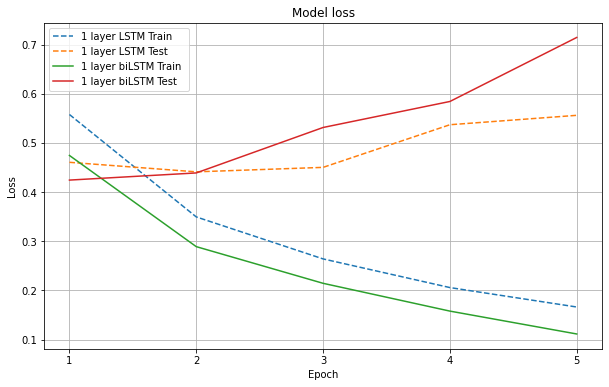

In [33]:
# Plot training & validation loss values
import matplotlib.pyplot as plt

epoch_list = np.arange(1,n_epochs+1)

plt.figure(figsize=(10,6))
plt.grid()
plt.xticks(epoch_list)
# results for 1-layer lstm model
plt.plot(epoch_list, results_one_layer.history['loss'], "--", label="1 layer LSTM Train")
plt.plot(epoch_list, results_one_layer.history['val_loss'], "--", label = "1 layer LSTM Test")

# results for bi-lstm model
plt.plot(epoch_list, results_biLSTM.history['loss'], label="1 layer biLSTM Train ")
plt.plot(epoch_list, results_biLSTM.history['val_loss'], label = "1 layer biLSTM Test")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show();

## Challenge

You will be expected to use an Keras LSTM for a classicification task on the *Sprint Challenge*. 

--------
# 3. LSTM Text generation with Keras (Learn)

Using sequential models to generate text data is a very popular application of recursive deep learning models. A couple of popular applications are [**chat bots**](https://hackernoon.com/deep-learning-chatbot-everything-you-need-to-know-r11jm30bc) and language translators such as [**google translate**](https://ai.googleblog.com/2020/06/recent-advances-in-google-translate.html). 

In order to properly build a chat bot or translater you need to use multiple lstm models in an encoder & decoder framwork known as a [**sequence 2 sequence model**](https://keras.io/examples/nlp/lstm_seq2seq/) .


![](https://jeddy92.github.io/images/ts_intro/seq2seq_lang.png)

Also, now a days, using a standard LSTM isn't enough. You also have to use a version of lstm seq2seq models known as [**transformers**](https://towardsdatascience.com/transformers-141e32e69591). Transformers give seq2seq models the capacity to pay attention to specific portions of the input sequence, the most relevent portion in order to make a prediction. Yes, that's right, humanity has figured out how to convert attention into an algorithm. Next stop, self-awareness! 

The above mentions of sequence 2 sequence models and transformers are for a larger contextual understanding of the landscape of language models and how LSTMs fit into this landscape. Although **we will cover the encoder/decoder framework in a future lesson, transformers are outside the scope of Unit 4**. However, once you learn about LSTMs and encoder/decoder frameworks, you will have all necessary information to then go on and learn about transformers on your own. At that point, the only really new bit you'll be learning is the [**attention mechanism**](https://towardsdatascience.com/intuitive-understanding-of-attention-mechanism-in-deep-learning-6c9482aecf4f). 


As a first pass at text generation, we'll stick to standard LSTM models. 

-----
# Text Generation using LSTMs

What else can we do with LSTMs? Since we're analyzing the *sequence*, we can do more than classify - we can *generate* text. <br>
For this exercise, we'll use BBC news articles from the [newspaper](https://github.com/codelucas/newspaper/)  database.

This example is drawn from the Keras [documentation](https://keras.io/examples/lstm_text_generation/).

In [35]:
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

import tensorflow as tf
from tensorflow.keras.preprocessing import sequence

import re
import numpy as np
import pandas as pd
import random
import sys
import os

# import a custom text data preparation class
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/main/module1-rnn-and-lstm/data_cleaning_toolkit_class.py
from data_cleaning_toolkit_class import data_cleaning_toolkit

--2021-11-09 03:16:20--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/main/module1-rnn-and-lstm/data_cleaning_toolkit_class.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6666 (6.5K) [text/plain]
Saving to: ‘data_cleaning_toolkit_class.py’

data_cleaning_toolk 100%[===================>]   6.51K  --.-KB/s    in 0s      

2021-11-09 03:16:20 (67.4 MB/s) - ‘data_cleaning_toolkit_class.py’ saved [6666/6666]



In [36]:
# load text data (articles)
df = pd.read_json('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/main/module1-rnn-and-lstm/wp_articles.json')
df.head()

,article
0,Contributing columnist\n\nThe House is on fire...
1,When President Trump announced his decision to...
10,Russian President Vladimir Putin speaks at a s...
100,“The Queen’s Speech” is designed to acknowledg...
101,"Like an aging rock star, the president is now ..."


How many articles are in the database?

In [37]:
len(df)

136

The [`data_cleaning_toolkit()`](https://github.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/blob/main/module1-rnn-and-lstm/data_cleaning_toolkit_class.py)<br>
* Cleans the documents<br>
* Chops them into text strings of length `max_len` (default = 20) characters<br>
* Creates the X and y split with the appropriate shapes to use with an RNN or LSTM model<br><br>
For this  problem: <br>
X is the input data -- the corpus of news articles, arranged in 20 character sequences, for which we want to predict the next character. <br>
The dimension of X is [n_sequences, sequence_length, n_vocab]<br>
The rows correspond to 20 character text sequences<br><br>
In order to have more training data, each sequence starts at a position shifted forward by an integer step, compared to the previous text string<br><br>
y is the "next" character that we are trying to predict for each sequence. y is a one-hot-encoded, of dimension [n_sequences, n_vocab]



In [38]:
df

,article
0,Contributing columnist\n\nThe House is on fire...
1,When President Trump announced his decision to...
10,Russian President Vladimir Putin speaks at a s...
100,“The Queen’s Speech” is designed to acknowledg...
101,"Like an aging rock star, the president is now ..."
...,...
95,"Approaching its 150th birthday Nov. 6, college..."
96,A few factors contributed to this placid accep...
97,"On Thursday, four days after he set out on his..."
98,A South Carolina sheriff candidate is fessing ...


In [39]:
dctk = data_cleaning_toolkit()

In [40]:
###BEGIN SOLUTION 
# instantiate data cleaning toolkit
dctk = data_cleaning_toolkit()

# use regex to clean documents, applying the clean_data method from dctk
df['clean_data'] = df.article.apply(lambda text: dctk.clean_data(text))
print(len(df['clean_data']))

# move articles to an array of strings
data = df['clean_data'].values
print(len(data))

# number of chars in each sequence 
doc_len = 20

# numerically encode the sequences, using the create_char_sequences method from dctk
dctk.create_char_sequences(data, doc_len)

136
136
Created 168985 sequences.


Here is the first article

In [41]:
(df['article'][0])

"Contributing columnist\n\nThe House is on fire. And with each passing day, Donald Trump defiles the office of the president. If only past defrocked presidents could provide a roadmap for this firestorm.\n\nAndrew Johnson fought impeachment vigorously and survived removal, but never won reelection. Richard Nixon got in the way of justice, but eventually bowed to the rule of law, accepting his asterisk in the annals of history and resigning before certain removal. Bill Clinton expressed contrition, went on to complete his presidency with high approval ratings and has remained a popular former president.\n\nIf you care about democracy, the rule of law and nearly 250 years of constitutional governance, take heed. President Trump is no Clinton or Nixon, or even Johnson. He will not go quietly. It will be ugly. He will betray us and the rule of law in the process — defying subpoenas, withholding documents, blocking witnesses.\n\nThis presidency is fouled with disrespect for rules, boundarie

`data` is an array containing the cleaned articles.<br>
Here is the cleaned version of the first article

In [43]:
data[0]

'contributing columnistthe house is on fire and with each passing day donald trump defiles the office of the president if only past defrocked presidents could provide a roadmap for this firestormandrew johnson fought impeachment vigorously and survived removal but never won reelection richard nixon got in the way of justice but eventually bowed to the rule of law accepting his asterisk in the annals of history and resigning before certain removal bill clinton expressed contrition went on to complete his presidency with high approval ratings and has remained a popular former presidentif you care about democracy the rule of law and nearlyyears of constitutional governance take heed president trump is no clinton or nixon or even johnson he will not go quietly it will be ugly he will betray us and the rule of law in the processdefying subpoenas withholding documents blocking witnessesthis presidency is fouled with disrespect for rules boundaries and norms trump walked away from major agree

Let's explore the `dctk` class we just instantiated

In [44]:
type(dctk)
dir(dctk)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'char_int',
 'clean_data',
 'create_X_and_Y',
 'create_char_sequences',
 'int_char',
 'maxlen',
 'n_features',
 'next_char',
 'sequences',
 'unique_chars']

`dctk.create_char_sequences()` first joins the text strings of the corpus of 136 documents into into a single text string, then splits that string into overlapping 20-character sequences, where the starting positions of the sequences are multiples of 5.



`dctk.create_char_sequences()` <br>
* produces a list `dctk.sequences` which contains 168985 20-character sequences from the input data, with each character encoded by the integer position in the character dictionary.<br>
* produces a list `dctk.next_char` which contains the next character for each of the 168985 20-character sequences, encoded as its index in the character vocabulary.<br>

In [46]:
print('The ',len(dctk.unique_chars),' unique characters are ',dctk.unique_chars)
print(type(dctk.sequences))
print('There are ',len(dctk.sequences),'sequences')
display(dctk.sequences[:2])


The  27  unique characters are  ['d', 'c', 'z', 's', 'v', 'f', 'y', 'p', 'j', 'q', 'o', 'i', 'l', 'e', 'w', ' ', 'a', 'x', 'g', 'm', 'r', 'h', 'b', 'k', 't', 'u', 'n']
<class 'list'>
There are  168985 sequences


[[1,
  10,
  26,
  24,
  20,
  11,
  22,
  25,
  24,
  11,
  26,
  18,
  15,
  1,
  10,
  12,
  25,
  19,
  26,
  11],
 [11,
  22,
  25,
  24,
  11,
  26,
  18,
  15,
  1,
  10,
  12,
  25,
  19,
  26,
  11,
  3,
  24,
  24,
  21,
  13]]

For each sequence, `dctk.next_char` contains the integer encoding for the next character we are trying to predict. Here are the values of `next_char` for the first 10 sequences:

In [48]:
print(len(dctk.next_char))
dctk.next_char[:10]

168985


[3, 15, 13, 10, 20, 0, 21, 21, 3, 0]

The `dctk.create_X_and_Y` method produces X and y, which are the 1-hot encodings for the `sequence` and `next_char`.<br>
The dimension of X will be (168985, 20, 27) and the dimension of y will be (168985, 27)

In [49]:
# create X and y split
X, y = dctk.create_X_and_Y()
###END SOLUTION 

Each character is represented as a one-hot encoded vector of length 27, with <br>
positions corresponding to the "vocabulary" of all the possible characters. <br>
There are 27 possible characters, including the space.

In [50]:
print(type(X))
print(X.shape)

<class 'numpy.ndarray'>
(168985, 20, 27)


Here is the one-hot encoding of the first character in the first sequence

In [51]:
print(X[0,0,:])
np.argmax(X[0,0,:])

[False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]


1

In [54]:
dctk.int_char[np.argmax(X[0,0,:])]

'c'

The rows of y are the one-hot encodings of `next_char` 

In [55]:
print(type(y))
print(y.shape)
print(y[0,:])
print(np.argmax(y[0,:]))

<class 'numpy.ndarray'>
(168985, 27)
[False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False]
3


In [56]:
y[0]

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [57]:
dctk.int_char[np.argmax(y[0,:])]

's'

In [61]:
###BEGIN SOLUTION
# dctk.sequences is our encoded doc-term matrix 
print(len(dctk.sequences))

# each doc is maxlen values long 
print(len(dctk.sequences[0]))

# want to know what this encoded document actually says?
# you'll need to the char-int look up dictionaries 
print(dctk.sequences[0])



168985
20
[1, 10, 26, 24, 20, 11, 22, 25, 24, 11, 26, 18, 15, 1, 10, 12, 25, 19, 26, 11]


`dctm` also produces character-to-integer and integer-to-character dictionaries

In [62]:
# character to index dictionary
# keys are chars
# vlaues are ints
print(dctk.char_int)

# index to char dictionary
# keys are ints
# values are chars
print(dctk.int_char)

{'d': 0, 'c': 1, 'z': 2, 's': 3, 'v': 4, 'f': 5, 'y': 6, 'p': 7, 'j': 8, 'q': 9, 'o': 10, 'i': 11, 'l': 12, 'e': 13, 'w': 14, ' ': 15, 'a': 16, 'x': 17, 'g': 18, 'm': 19, 'r': 20, 'h': 21, 'b': 22, 'k': 23, 't': 24, 'u': 25, 'n': 26}
{0: 'd', 1: 'c', 2: 'z', 3: 's', 4: 'v', 5: 'f', 6: 'y', 7: 'p', 8: 'j', 9: 'q', 10: 'o', 11: 'i', 12: 'l', 13: 'e', 14: 'w', 15: ' ', 16: 'a', 17: 'x', 18: 'g', 19: 'm', 20: 'r', 21: 'h', 22: 'b', 23: 'k', 24: 't', 25: 'u', 26: 'n'}


#### Check that the character encoding works properly
Use the integer-to-character dictionary to map the integer character encodings back to the characters they represent

In [63]:
# (num_seqs, seq length, num features)
X.shape

(168985, 20, 27)

In [64]:
dctk.sequences[0]

[1, 10, 26, 24, 20, 11, 22, 25, 24, 11, 26, 18, 15, 1, 10, 12, 25, 19, 26, 11]

In [65]:
# now we can check to see that our encoding is correct 
for ind in dctk.sequences[0]:
    print (dctk.int_char[ind])
    
# number of features is the total number of unique chars in our corpos 
print(dctk.n_features)

# (num_seqs, num features)
###END SOLUTION

c
o
n
t
r
i
b
u
t
i
n
g
 
c
o
l
u
m
n
i
27


Each successive sequence (after the first) starts with the 5th character of the previous sequence

> Indented block



In [66]:
for ind in dctk.sequences[1]:
    print (dctk.int_char[ind])

i
b
u
t
i
n
g
 
c
o
l
u
m
n
i
s
t
t
h
e


We are building a language model to predict the next character in a sequence, <br>
so each y corresponds to the next character after the 20th character of the sequence!

In [69]:
print(y.shape)
print(y[0])
print(np.argmax(y[0]))
print (dctk.int_char[np.argmax(y[0])])

(168985, 27)
[False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False]
3
s


The code that generates `X` and `y` is in `data_cleaning_toolkit` method `create_X_and_Y()`.<br><br>
For the sequence in the $i\text{th}$ row of `X`, the character the language model is trying to predict should be the character that comes after the 20th character. If there were no overlap between rows, this would be the first character in the next row. But each row starts with the 5th character in the previous row. So the 21st character is actually the 16th character in the next row, i.e. at index 15! <br><br>



In [71]:
print(np.argmax(y[0]))
print( [np.argmax(X[1,i,:]) for i in range(20) ])

3
[11, 22, 25, 24, 11, 26, 18, 15, 1, 10, 12, 25, 19, 26, 11, 3, 24, 24, 21, 13]


In [72]:
print(np.argmax(y[1]))
print( [np.argmax(X[2,i,:]) for i in range(20) ])

15
[26, 18, 15, 1, 10, 12, 25, 19, 26, 11, 3, 24, 24, 21, 13, 15, 21, 10, 25, 3]


In [ ]:
print(np.argmax(y[2]))
print( [np.argmax(x[3,i,:]) for i in range(20) ])

7
[1, 17, 12, 5, 0, 16, 18, 18, 6, 7, 26, 6, 19, 17, 16, 7, 26, 0, 16, 26]


### Callback function `on_epoch_end` 
Provides feedback at the end of each epoch to help you gauge how your model is progressing:<br>
Takes a sequence of 20 consecutive characters starting at a _randomly chosen_ position <br>
in the articles corpus, predicts the next 20 characters using the current version <br>
of the trained model, and prints these results.

`sample` is a helper function that generates a character by drawing a sample from a predicted probability distribution.<br>
`temperature` is a hyper-parameter that, if different from 1, warps (narrows or broadens) the predicted probability distribution. <br>
This can add some variety to the generated characters.

In [73]:
def sample(preds, temperature=1.0):
    """
    Helper function to generate a sample character
    Input is a predictions vector from our model, for example a set of 27 character probabilities
    Output is the index of the generated character 
    """
    # convert predictions to an array 
    preds = np.asarray(preds).astype('float64')

    # use the temperature hyper-parameter to "warp" (sharpen or spread out) the probability distribution 
    preds = np.log(preds) / temperature

    # use the softmax activation function to create a new list of probabilities 
    #   corresponding to the "warped" probability distribution
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    # Draw a single sample from a multinomial distribution, given these probabilities
    #   The sample will be a one-hot encoded character
    """ Notes on the np.random.multinomial() function 
       The first argument is the number of "trials" we want: 1 in this case
       The second argument is the list of probabilities for each character
       The third argument is number of sets of "trials" we want: again, 1 in this case
       By analogy with a dice-rolling experiment: 
          A "trial" consists of generating a single "throw" of a die with 27 faces;
             each face corresponds to a character and its associated probability
    """

    probas = np.random.multinomial(1, preds, 1)
    
    # return the index that corresponds to the max probability 
    return np.argmax(probas)


Create the `on_epoch_end` function to be passed into `LambdaCallback()`

In [74]:
def on_epoch_end(epoch, _):
    """"
    Function invoked at end of each epoch. 
    Prints the text generated by the current version of the model at this point
    """
    
    print()
    print('----- Generating text after Epoch: %d' % epoch)


    # randomly draw a starting position in the corpus
    start_index = random.randint(0, len(text) - dctk.maxlen - 1)
    
    # Initialize the "seed" string with maxlen consecutive characters beginning at start_index
    seed = text[start_index: start_index + dctk.maxlen]

    # number of consecutive characters to generate to follow the seed text
    n_characters = 20
        
    print('----- Generating with seed: "' + seed + '"')
    sys.stdout.write(seed)
    
    # generate n_characters predicted by the model to follow the seed string
    for _ in range(n_characters):
        
        # initialize an array to hold the current seed string 
        #    in numerical form (i.e. one-hot encoded)
        # so the seed string is represented by an array of size (1, maxlen, 27)
        x_seed = np.zeros((1, dctk.maxlen, dctk.n_features))
        
        # create the one-hot encoded numerical representation of the seed string,
        for index, char in enumerate(seed):
            x_seed[0, index, dctk.char_int[char]] = 1
            
        # get the predicted probability distribution (for the next character
        #    after the seed string) from the current model
        preds = model.predict(x_seed, verbose=0)[0]

        # generate the character _index_ of the next character from a probability distribution based on the predicted probabilities
        char_index = sample(preds)
        # convert the character _index_ to the corresponding _character_ using the index-to-character dictionary
        char = dctk.int_char[char_index]
        
        # update the seed string by _dropping_ the first character and _adding_ the generated character at the end,
        #   thus forming the 20 character sequence for the next prediction
        seed = seed[1:] + char
        
        # use the flush() function to prepare to write the next character
        sys.stdout.write(char)
        sys.stdout.flush()
    print()

In [75]:
# join all the news articles into one long super-long text string
# need this for on_epoch_end()
text = " ".join(data)
print(len(text))

844942


In [76]:
# create callback object that will print out text generation at the end of each epoch 
# use for real-time monitoring of model performance
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

---------
### Build a Text Generating Model from the News Articles Corpus
We see that within 50 epochs, the model has begun to learn to form intelligible words, <br>and it's still slowly training, i.e. the loss function is decreasing at each epoch. <br>
By 150 epochs, the generated text usually includes one or more recognizable words per 20 characters. 

Set up the Adam optimizer to allow changing the learning rate

In [77]:
%%time
### BEGIN SOLUTION
## Takes about 4.5 minutes to train the entire corpus for 50 epochs on a colab GPU (1 LSTM layer, 128 neurons)

# build a 1 layer LSTM language model 
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.001)

model = Sequential()

# hidden layer 1 
model.add(LSTM(128, 
               input_shape=(dctk.maxlen, dctk.n_features), # input_shape is (20,27)
               return_sequences=False)) # set to true whenever using 2 or more LSTM layers 

# this is our output layer
# recall that n_features = number of characters in the dictionary = 27
model.add(Dense(dctk.n_features, 
                activation='softmax'))

# notice that we are using categorical_crossentropy this time around - why?
model.compile(loss='categorical_crossentropy', 
              optimizer=opt)

# fit the model
# X and y are pretty large, consider sub-sampling
model.fit(X, y,
          batch_size=128,
          epochs=150,
          callbacks=[print_callback])
### END SOLUTION

Epoch 1/150
1321/1321 [==============================] - 7s 4ms/step - loss: 2.4341

----- Generating text after Epoch: 0
----- Generating with seed: "anent member of the "
anent member of the sofdtont bles hutl k
Epoch 2/150
1321/1321 [==============================] - 5s 4ms/step - loss: 2.1466

----- Generating text after Epoch: 1
----- Generating with seed: "tseason run he has s"
tseason run he has singeare ficruh shack
Epoch 3/150
1321/1321 [==============================] - 5s 4ms/step - loss: 2.0268

----- Generating text after Epoch: 2
----- Generating with seed: "t is truly measuring"
t is truly measuring protes in us ranal 
Epoch 4/150
1321/1321 [==============================] - 5s 4ms/step - loss: 1.9405

----- Generating text after Epoch: 3
----- Generating with seed: "t the us had abandon"
t the us had abandon floumusein dote tre
Epoch 5/150
1321/1321 [==============================] - 5s 4ms/step - loss: 1.8720

----- Generating text after Epoch: 4
----- Generating with 

-------------
## Challenge

You will be expected to use a Keras LSTM to generate text on today's assignment. 

# Review

- <a href="#p1">Part 1: </a>Describe Neural Networks used for modeling sequences
    * Sequence Problems:
        - Text Classification
        - Text Generation
        - Machine Translation
        - Time Series Forecasting (like Stock Prices, Weather, etc.)
    * LSTMs are generally preferred over RNNs for most problems
    * LSTMs generally use 1 or 2 hidden layers.
    * Keras has LSTMs/RNN layer types implemented nicely
- <a href="#p2">Part 2: </a>Apply LSTMs to a text classification problem and to a text generation problem using TensorFlow/Keras
    * The shape of the input data for an LSTM is important
    * LSTMs can take a while to train
    * You can use LSTMs to write movie scripts. :P 